##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Cifar-3 Image classification Challenge
Adapted from official tensorflow image classification tutorial: https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb

## Imports and Constants

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import constraints

In [3]:
with np.load('prediction-challenge-02-data.npz') as fh:
    challenge_x_train = fh['x_train']
    challenge_y_train = fh['y_train']
    challenge_x_test = fh['x_test']

# TRAINING DATA: INPUT (x) AND OUTPUT (y)
# 1. INDEX: IMAGE SERIAL NUMBER (6000)
# 2/3. INDEX: PIXEL VALUE (32 x 32)
# 4. INDEX: COLOR CHANNELS (3)
print(f"Training data shape: {challenge_x_train.shape}, type: {challenge_x_train.dtype}")
print(f"Training labels shape: {challenge_y_train.shape}, type: {challenge_y_train.dtype}")

# TEST DATA: INPUT (x) ONLY
print(f"Test data shape: {challenge_x_test.shape}, type: {challenge_x_test.dtype}")

Training data shape: (3000, 32, 32, 3), type: float32
Training labels shape: (3000,), type: float64
Test data shape: (300, 32, 32, 3), type: float32


In [4]:
BATCH_SIZE = 32
IMG_HEIGHT = challenge_x_train.shape[1]
IMG_WIDTH = challenge_x_train.shape[2]
VAL_SIZE = 0.2
TEST_SIZE = 0.1
CLASSES = {0:"cat",1:"dog",2:"frog"}
NUM_CLASSES = len(CLASSES)

## Visualize Examples

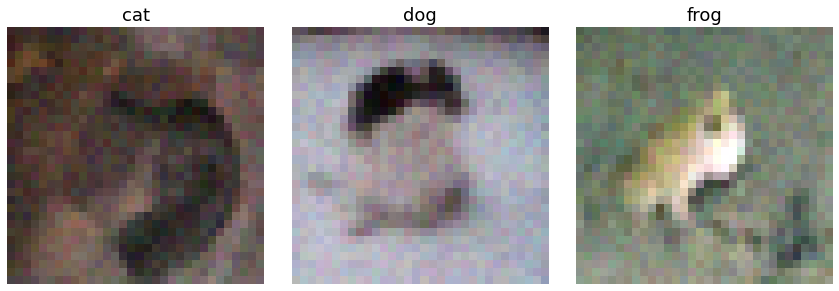

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=len(CLASSES), figsize=(4*len(CLASSES), 4))

for class_id in CLASSES:
    axes[class_id].set_title(CLASSES[class_id], size=18)
    axes[class_id].imshow(challenge_x_train[np.where(challenge_y_train == class_id)[0][0]])
    axes[class_id].axis("off")
fig.tight_layout()
plt.show()

## Training - Validation - Test - Split

In [6]:
x, x_test, y, y_test = train_test_split(challenge_x_train,challenge_y_train, test_size=TEST_SIZE,shuffle=True,random_state=71,stratify=challenge_y_train)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=VAL_SIZE, shuffle=True, stratify=y)

x = np.concatenate((x_train, x_val))
y = np.concatenate((y_train, y_val))

In [7]:
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=VAL_SIZE)
train_ds = img_gen.flow(x,y,batch_size=BATCH_SIZE,shuffle=True,seed=28,subset="training")
val_ds = img_gen.flow(x,y,batch_size=BATCH_SIZE,shuffle=True,seed=28, subset="validation")

## Data augmentation

In [8]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(IMG_HEIGHT, 
                                                              IMG_WIDTH,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

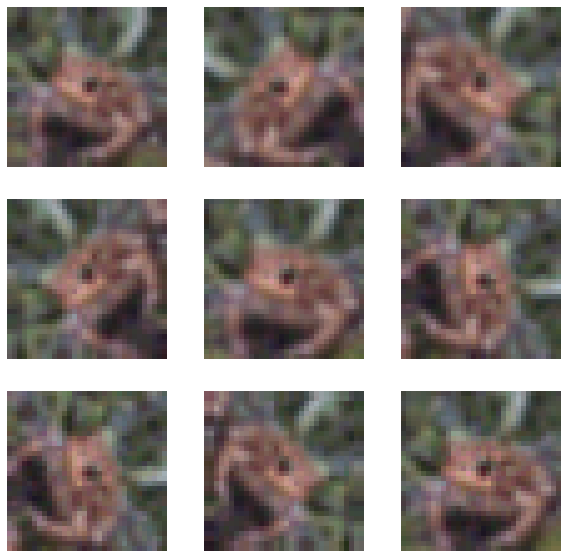

In [9]:
plt.figure(figsize=(10, 10))
images, _ = train_ds[2]
for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0])
    plt.axis("off")

## Model Definition

In [10]:
model = Sequential([
    data_augmentation,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)         

## Training

In [13]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
68/68 [==============================] - 2s 9ms/step - loss: 1.0704 - accuracy: 0.4051 - val_loss: 1.0881 - val_accuracy: 0.4148
Epoch 2/50
68/68 [==============================] - 0s 5ms/step - loss: 0.9850 - accuracy: 0.5056 - val_loss: 0.9668 - val_accuracy: 0.5222
Epoch 3/50
68/68 [==============================] - 0s 5ms/step - loss: 0.9543 - accuracy: 0.5301 - val_loss: 0.9498 - val_accuracy: 0.5111
Epoch 4/50
68/68 [==============================] - 0s 5ms/step - loss: 0.9338 - accuracy: 0.5315 - val_loss: 1.0322 - val_accuracy: 0.4426
Epoch 5/50
68/68 [==============================] - 0s 5ms/step - loss: 0.9096 - accuracy: 0.5537 - val_loss: 0.9128 - val_accuracy: 0.5611
Epoch 6/50
68/68 [==============================] - 0s 5ms/step - loss: 0.8820 - accuracy: 0.5736 - val_loss: 0.8679 - val_accuracy: 0.6000
Epoch 7/50
68/68 [==============================] - 0s 5ms/step - loss: 0.8582 - accuracy: 0.5884 - val_loss: 0.8783 - val_accuracy: 0.5852
Epoch 8/50
68/68 [==

## Visualize Metrics

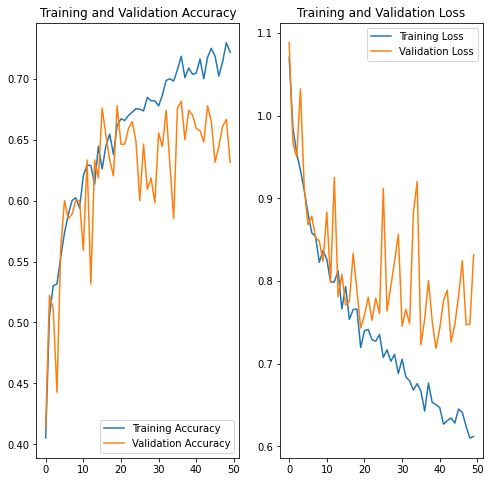

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Prediction

In [15]:
predictions = model.predict(x_test)
score = tf.nn.softmax(predictions)
print(f"Accuracy on custom test set: {np.sum(np.argmax(score, axis=1)== y_test) / y_test.shape[0]}")

Accuracy on custom test set: 0.6433333333333333


### Challenge Prediction

In [16]:
prediction = np.argmax(tf.nn.softmax(model.predict(challenge_x_test)),axis=1)

# MAKE SURE THAT YOU HAVE THE RIGHT FORMAT
assert prediction.ndim == 1
assert prediction.shape[0] == 300

# AND SAVE EXACTLY AS SHOWN BELOW
np.save('prediction.npy', prediction.astype(int))

# MAKE SURE THAT THE FILE HAS THE CORRECT FORMAT
def validate_prediction_format():
    loaded = np.load('prediction.npy')
    assert loaded.shape == (300, )
    assert loaded.dtype == int
    assert (loaded <= 2).all()
    assert (loaded >= 0).all()
    
validate_prediction_format()

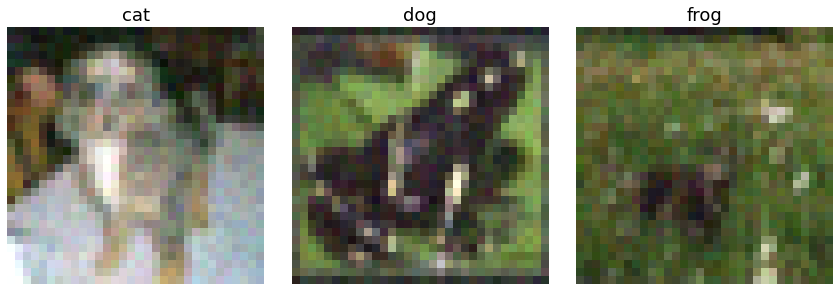

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=len(CLASSES), figsize=(4*len(CLASSES), 4))

for class_id in CLASSES:
    axes[class_id].set_title(CLASSES[class_id], size=18)
    axes[class_id].imshow(challenge_x_test[np.where(prediction == class_id)[0][0]])
    axes[class_id].axis("off")
fig.tight_layout()
plt.show()